# Groupby and Arrest Data

In our merging exercises, we examined the relationship between county-level violent arrest totals and county-level drug arrest totals. In those exercises, you were given a dataset that provided you with county-level arrest totals. But that's not actually how the data is provided by the state of California. This week we will work with the *raw* California arrest data, which is not organized by county or even county-year. 


In [203]:
import pandas as pd
import numpy as np

pd.set_option("mode.copy_on_write", True)

# Create a results dictionary
results = {}


## Gradescope Autograding

Please follow [all standard guidance](https://www.practicaldatascience.org/html/autograder_guidelines.html) for submitting this assignment to the Gradescope autograder, including storing your solutions in a dictionary called `results` and ensuring your notebook runs from the start to completion without any errors.

For this assignment, please name your file `exercise_groupby.ipynb` before uploading.

You can check that you have answers for all questions in your `results` dictionary with this code:

```python
assert set(results.keys()) == {
    "ex4_num_rows",
    "ex5_collapsed_vars",
    "ex7_alameda_1980_share_violent_arrestees_black",
    "ex11_white_drug_share",
    "ex11_black_drug_share",
    "ex12_proportionate",
}
```


### Submission Limits

Please remember that you are **only allowed three submissions to the autograder.** Your last submission (if you submit 3 or fewer times), or your third submission (if you submit more than 3 times) will determine your grade Submissions that error out will **not** count against this total.

### Exercise 1

Import the raw California arrest data from the State Attorney General's office. Please use [this link](https://github.com/nickeubank/MIDS_Data/blob/master/OnlineArrestData1980-2021.csv) (the original is here [here](https://openjustice.doj.ca.gov/data), but they keep updating it and I get tired of updating solutions, so... please use my copy!)

In [204]:
# URL of the dataset ca_arrests_2009.csv
arrest_data = "https://media.githubusercontent.com/media/nickeubank/MIDS_Data/master/OnlineArrestData1980-2021.csv"

# Reading the data from the URL into a pandas DataFrame
arrest = pd.read_csv(arrest_data)

## Learning the Group Structure of Your Data

### Exercise 2

What is the unit of observation for this dataset? In other words, when row zero says that there were 505 arrests for `VIOLENT` crimes, what exactly is that telling you—505 arrests in 1980? 505 arrests in Alameda County?

(Please answer in Markdown)

In [205]:
arrest.head()

,YEAR,GENDER,RACE,AGE_GROUP,COUNTY,VIOLENT,PROPERTY,F_DRUGOFF,F_SEXOFF,F_ALLOTHER,F_TOTAL,M_TOTAL,S_TOTAL
0,1980,Male,Black,Under 18,Alameda County,505,1351,188,26,79,2149,2286,295
1,1980,Male,Black,18 to 19,Alameda County,205,465,183,8,48,909,1333,0
2,1980,Male,Black,20 to 29,Alameda County,949,1593,606,27,178,3353,7974,0
3,1980,Male,Black,30 to 39,Alameda County,450,755,241,18,110,1574,4876,0
4,1980,Male,Black,40 to 69,Alameda County,172,218,117,11,66,584,3836,0


> The unit of observation for this dataset is arrests disaggregated by year, gender, race, age group, and county.
> The 505 arrests for VIOLENT crimes in row zero represent 505 number of arrests in Alameda County in the year 1980 for Black males under the age of 18.

### Testing Your Assumptions

It's important to be able to test whether the data you are working with really is organized the way you think it is, especially when working with groupby. Let's discuss how to check your answer to Exercise 2 with the `.duplicated()` method. 

Consider the following toy data:

In [206]:
import pandas as pd

df = pd.DataFrame(
    {
        "social_security_numbers": [
            111111111,
            222222222,
            222222222,
            333333333,
            333333333,
        ],
        "second_column": ["a", "a", "a", "a", "b"],
    }
)
df

,social_security_numbers,second_column
0,111111111,a
1,222222222,a
2,222222222,a
3,333333333,a
4,333333333,b


If we want to see if there are any duplicate rows in the dataset, we can use the `.duplicated()` method:

In [207]:
df.duplicated()

0    False
1    False
2     True
3    False
4    False
dtype: bool

As you can see, `.duplicated()` looks at each row and returns `True` if it has seen the row it is looking at before. 

Notice that `.duplicted()` doesn't return `True` for *all* rows that look the same as another row in the data—it treats the first instance of a row as unique, and only tags *subsequent* repetitions as "duplicates" (You can change this behavior with the `keep` keyword argument if you want).

`.duplicated()` can also be used to test for rows that are duplicates in terms of a sub-set of columns. For example, `df.duplicated(["social_security_numbers"])` identifies rows with duplicate values of the variable `social_security_numbers`:

In [208]:
df.duplicated(["social_security_numbers"])

0    False
1    False
2     True
3    False
4     True
dtype: bool

Since `duplicated` is now only looking at `social_security_numbers` (not all values in a row), the last row is now a duplicate (because `333333333` is duplicated), where when we considered all columns, it was not a duplicate. 

### Testing with .duplicated()

`.duplicated()` can be paired with the `.any()` method to write `assert` tests to detect the presence of duplicates in our dataset and to validate our assumptions about whether certain variables uniquely identify observations in our data.

When you run `.any()` on an array of Booleans, it returns a single value of `True` if *any* entries are `True`, and a single value of `False` if *no* entries are `True`. (You can also use `.all()` to test if all entries are `False`).

Thus the command `df.duplicated(['social_security_numbers'])` will return `False` if `social_security_numbers` uniquely identifies every row in our dataset (since there are no duplicates)! But if there *are* any duplicates, it will return `True`:

In [209]:
df.duplicated(["social_security_numbers"]).any()

True

So if I wanted a test that would raise an `Error` if it turned out that `social_security_numbers` *didn't* uniquely identify observations, I would combine that code with `assert not`:

```python
assert not df.duplicated(["social_security_numbers"]).any()

---------------------------------------------------------------------------
AssertionError                            Traceback (most recent call last)
Cell In [20], line 1
----> 1 assert not df.duplicated(["social_security_numbers"]).any()

AssertionError: 
```

(which in this case raises an Error because `social_security_numbers` *isn't* unique!)

BTW, if this feels oddly familiar, that's probably because we talked about this same idea when discussing merging. A `1:1` merge is one in which the merging variables uniquely identify observations in both datasets.

### Exercise 3

Use `duplicated` to test if the variables *you* think uniquely identify rows in your data really do uniquely identify rows. If you were wrong, update your beliefs (and your code) until you have an `assert` statement that passes.

In [210]:
arrest.head()

,YEAR,GENDER,RACE,AGE_GROUP,COUNTY,VIOLENT,PROPERTY,F_DRUGOFF,F_SEXOFF,F_ALLOTHER,F_TOTAL,M_TOTAL,S_TOTAL
0,1980,Male,Black,Under 18,Alameda County,505,1351,188,26,79,2149,2286,295
1,1980,Male,Black,18 to 19,Alameda County,205,465,183,8,48,909,1333,0
2,1980,Male,Black,20 to 29,Alameda County,949,1593,606,27,178,3353,7974,0
3,1980,Male,Black,30 to 39,Alameda County,450,755,241,18,110,1574,4876,0
4,1980,Male,Black,40 to 69,Alameda County,172,218,117,11,66,584,3836,0


> From our observation, there does not appear to have a single variable that can uniquely identify each row in this data. 
> The combination of "YEAR," "GENDER," "RACE," "AGE_GROUP," and "COUNTY" together could potentially act as a composite key to uniquely identify each row, assuming that there are no two rows with the same values for all these columns.

In [211]:
# Check if the combination of "YEAR," "GENDER," "RACE," "AGE_GROUP," and "COUNTY" together could uniquely identify rows in my data.
arrest.duplicated(subset=["YEAR", "GENDER", "RACE", "AGE_GROUP", "COUNTY"]).any()

False

In [212]:
# test our belief that there are no duplicates combination of "YEAR," "GENDER," "RACE," "AGE_GROUP," and "COUNTY" in the data
assert not arrest.duplicated(
    subset=["YEAR", "GENDER", "RACE", "AGE_GROUP", "COUNTY"]
).any()  # no duplicates, test passed

### Exercise 4

Once you have a handle on how the data looks now, please **collapse the data** to be one observation per county-year-racial group. Store the number of rows in the resulting dataframe in your `results` dictionary under the key `"ex4_num_rows"`.

**Hint:** Think carefully about the most appropriate *aggregation function* (e.g., mean, median, sum, count) given the data we're working with!

**Hint 2:** When using `groupby`, I am a HUGE fan of the `as_index=False` keyword argument (e.g., `df.groupby("col1", as_index=False).mean()`). By default when you use groupby, pandas likes to make a new index out of the grouping columns. As you know, I HATE indices, and this keyword argument prevents pandas from this behavior. To illustrate:

In [213]:
df = pd.DataFrame(
    {
        "social_security_numbers": [
            111111111,
            222222222,
            222222222,
            222222222,
            333333333,
        ],
        "second_column": ["a", "a", "b", "a", "b"],
        "third_column": [100, 200, 300, 400, 500],
    }
)
df

,social_security_numbers,second_column,third_column
0,111111111,a,100
1,222222222,a,200
2,222222222,b,300
3,222222222,a,400
4,333333333,b,500


In [214]:
# Without as_index=False
df.groupby(["social_security_numbers", "second_column"]).mean()

third_column
social_security_numbers second_column              
111111111               a                     100.0
222222222               a                     300.0
                        b                     300.0
333333333               b                     500.0

In [215]:
# With as_index=False
df.groupby(["social_security_numbers", "second_column"], as_index=False).mean()

,social_security_numbers,second_column,third_column
0,111111111,a,100.0
1,222222222,a,300.0
2,222222222,b,300.0
3,333333333,b,500.0


In [216]:
arrest_group = arrest.groupby(["COUNTY", "YEAR", "RACE"], as_index=False).sum()
arrest_group

,COUNTY,YEAR,RACE,GENDER,AGE_GROUP,VIOLENT,PROPERTY,F_DRUGOFF,F_SEXOFF,F_ALLOTHER,F_TOTAL,M_TOTAL,S_TOTAL
0,Alameda County,1980,Black,MaleMaleMaleMaleMaleMaleFemaleFemaleFemaleFema...,Under 1818 to 1920 to 2930 to 3940 to 6970 and...,2594,5138,1489,94,541,9856,24081,555
1,Alameda County,1980,Hispanic,MaleMaleMaleMaleMaleMaleFemaleFemaleFemaleFema...,Under 1818 to 1920 to 2930 to 3940 to 6970 and...,592,903,361,34,279,2169,10120,333
2,Alameda County,1980,Other,MaleMaleMaleMaleMaleMaleFemaleFemaleFemaleFema...,Under 1818 to 1920 to 2930 to 3940 to 6970 and...,139,233,69,10,64,515,2686,92
3,Alameda County,1980,White,MaleMaleMaleMaleMaleMaleFemaleFemaleFemaleFema...,Under 1818 to 1920 to 2930 to 3940 to 6970 and...,1179,3103,1650,119,767,6818,34455,1358
4,Alameda County,1981,Black,MaleMaleMaleMaleMaleMaleFemaleFemaleFemaleFema...,Under 1818 to 1920 to 2930 to 3940 to 6970 and...,2753,5533,1460,90,650,10486,25740,632
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9697,Yuba County,2020,White,MaleMaleMaleMaleMaleMaleFemaleFemaleFemaleFema...,Under 1818 to 1920 to 2930 to 3940 to 6970 and...,179,93,69,9,85,435,1157,0
9698,Yuba County,2021,Black,MaleMaleMaleMaleMaleFemaleFemaleFemaleFemaleFe...,Under 1818 to 1920 to 2930 to 3940 to 69Under ...,45,17,12,6,16,96,157,0
9699,Yuba County,2021,Hispanic,MaleMaleMaleMaleMaleFemaleFemaleFemaleFemaleFe...,Under 1818 to 1920 to 2930 to 3940 to 69Under ...,84,28,20,1,50,183,328,0
9700,Yuba County,2021,Other,MaleMaleMaleMaleMaleFemaleFemaleFemaleFemale,Under 1820 to 2930 to 3940 to 6970 and overUnd...,11,13,12,0,14,50,122,0


In [217]:
ex4_num_rows = arrest_group.shape[0]
results["ex4_num_rows"] = ex4_num_rows
# print(results)

### Exercise 5

You should notice that there are significantly fewer rows in the data now. Given your answer from 3, what groups were you *collapsing* in question 4 (in other words, which different groups were previously split out into separate rows but have now been aggregated into the same rows)?

Store the names of those variables **in a `list` in alphabetical order** in `results` as `"ex5_collapsed_vars"`.

In [218]:
# number of rows in the original dataset
arrest.shape[0]

102245

In [219]:
# number of rows in the grouped dataset
arrest_group.shape[0]

9702

> Before I collapsed the data, there are 102245 number of rows. After I collapsed the data , there are 9702 number of rows.
> The groups I collasped are age group and gender.

In [220]:
# Sort the list alphabetically
sorted_vars = sorted(["AGE_GROUP", "GENDER"])
results["ex5_collapsed_vars"] = sorted_vars
# print(results)

## Racial Arrest Composition

The next question we want to ask is: does the racial composition of arrests in each county vary by arrest type? In other words, do Blacks, Hispanics, Whites, and Other make up substantially different portions of the people arrested for drug offenses and violent offenses?

To answer this question, we need to be able to say what proportion of all drug arrestees were Black/White/Hispanic/Other and what proportion of all violent arrestees were Black/White/Hispanic/Other *for each county and for each year*.

In trying to do this, we'll need to break the problem down into pieces, starting from our goal (these quantities) and working backwards.

### Exercise 6

To calculate the share of all drug and violent arrestees who come from each racial group, what quantities do we need? 

Expressed differently, what two variables (one for drug arrests, one for violent arrests) do we need to add to our data to it allow us to calculate the share of arrestees in each county-year that come from a given racial group?

Calculate these two variables (one variable for drug arrests, one for violent arrests). 

**Hint:** `transform` should probably make an appearance here.

**Hint:** This types of groupby manipulations are an easy place to do things wrong, so it's important to eye-ball your data to be sure you did things right! 

Take a look at the data for, say, Alameda County in 1980, and compare the values that you calculate above with what you get if you try to calculate those same numbers by hand using the raw data from Exercise 5?

> The two varaibles I need are total number of drug arrests in each county-year, and total number of violent arrests in each county-year.

In [221]:
# Calculate the total number of drug arrestees for each racial group in each county-year
arrest_group["total_drug_arrest"] = arrest_group.groupby(["COUNTY", "YEAR"])[
    "F_DRUGOFF"
].transform("sum")

# Calculate the total number of violent arrestees for each racial group in each county-year
arrest_group["total_violent_arrest"] = arrest_group.groupby(["COUNTY", "YEAR"])[
    "VIOLENT"
].transform("sum")

arrest_group

,COUNTY,YEAR,RACE,GENDER,AGE_GROUP,VIOLENT,PROPERTY,F_DRUGOFF,F_SEXOFF,F_ALLOTHER,F_TOTAL,M_TOTAL,S_TOTAL,total_drug_arrest,total_violent_arrest
0,Alameda County,1980,Black,MaleMaleMaleMaleMaleMaleFemaleFemaleFemaleFema...,Under 1818 to 1920 to 2930 to 3940 to 6970 and...,2594,5138,1489,94,541,9856,24081,555,3569,4504
1,Alameda County,1980,Hispanic,MaleMaleMaleMaleMaleMaleFemaleFemaleFemaleFema...,Under 1818 to 1920 to 2930 to 3940 to 6970 and...,592,903,361,34,279,2169,10120,333,3569,4504
2,Alameda County,1980,Other,MaleMaleMaleMaleMaleMaleFemaleFemaleFemaleFema...,Under 1818 to 1920 to 2930 to 3940 to 6970 and...,139,233,69,10,64,515,2686,92,3569,4504
3,Alameda County,1980,White,MaleMaleMaleMaleMaleMaleFemaleFemaleFemaleFema...,Under 1818 to 1920 to 2930 to 3940 to 6970 and...,1179,3103,1650,119,767,6818,34455,1358,3569,4504
4,Alameda County,1981,Black,MaleMaleMaleMaleMaleMaleFemaleFemaleFemaleFema...,Under 1818 to 1920 to 2930 to 3940 to 6970 and...,2753,5533,1460,90,650,10486,25740,632,3926,4699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9697,Yuba County,2020,White,MaleMaleMaleMaleMaleMaleFemaleFemaleFemaleFema...,Under 1818 to 1920 to 2930 to 3940 to 6970 and...,179,93,69,9,85,435,1157,0,104,311
9698,Yuba County,2021,Black,MaleMaleMaleMaleMaleFemaleFemaleFemaleFemaleFe...,Under 1818 to 1920 to 2930 to 3940 to 69Under ...,45,17,12,6,16,96,157,0,112,355
9699,Yuba County,2021,Hispanic,MaleMaleMaleMaleMaleFemaleFemaleFemaleFemaleFe...,Under 1818 to 1920 to 2930 to 3940 to 69Under ...,84,28,20,1,50,183,328,0,112,355
9700,Yuba County,2021,Other,MaleMaleMaleMaleMaleFemaleFemaleFemaleFemale,Under 1820 to 2930 to 3940 to 6970 and overUnd...,11,13,12,0,14,50,122,0,112,355


In [222]:
# just keep county, year, race, violent, F_DRUGOFF, total drug arrest and total violent arrest in the arrest_group dataframe
arrest_group = arrest_group[
    [
        "COUNTY",
        "YEAR",
        "RACE",
        "VIOLENT",
        "F_DRUGOFF",
        "total_drug_arrest",
        "total_violent_arrest",
    ]
]
arrest_group

,COUNTY,YEAR,RACE,VIOLENT,F_DRUGOFF,total_drug_arrest,total_violent_arrest
0,Alameda County,1980,Black,2594,1489,3569,4504
1,Alameda County,1980,Hispanic,592,361,3569,4504
2,Alameda County,1980,Other,139,69,3569,4504
3,Alameda County,1980,White,1179,1650,3569,4504
4,Alameda County,1981,Black,2753,1460,3926,4699
...,...,...,...,...,...,...,...
9697,Yuba County,2020,White,179,69,104,311
9698,Yuba County,2021,Black,45,12,112,355
9699,Yuba County,2021,Hispanic,84,20,112,355
9700,Yuba County,2021,Other,11,12,112,355


### Exercise 7

Now calculate the share of violent and drug arrestees in each county and year from each racial group.

To ensure you're on the right track, store the share (between zero and one) of violent arrestees in Alameda County in 1980 who were Black as `ex7_alameda_1980_share_violent_arrestees_black`.

In [223]:
# Calculate the share of violent arrestees for each racial group in each county-year
arrest_group["share_violent_arrests"] = (
    arrest_group["VIOLENT"] / arrest_group["total_violent_arrest"]
)

# Calculate the share of drug arrestees for each racial group in each county-year
arrest_group["share_drug_arrests"] = (
    arrest_group["F_DRUGOFF"] / arrest_group["total_drug_arrest"]
)

arrest_group.head()

,COUNTY,YEAR,RACE,VIOLENT,F_DRUGOFF,total_drug_arrest,total_violent_arrest,share_violent_arrests,share_drug_arrests
0,Alameda County,1980,Black,2594,1489,3569,4504,0.575933,0.417204
1,Alameda County,1980,Hispanic,592,361,3569,4504,0.131439,0.101149
2,Alameda County,1980,Other,139,69,3569,4504,0.030861,0.019333
3,Alameda County,1980,White,1179,1650,3569,4504,0.261767,0.462314
4,Alameda County,1981,Black,2753,1460,3926,4699,0.585869,0.371880


In [224]:
# Filter for Alameda County, year 1980, and Black racial group
alameda_1980_black = arrest_group[
    (arrest_group["COUNTY"] == "Alameda County")
    & (arrest_group["YEAR"] == 1980)
    & (arrest_group["RACE"] == "Black")
]

# Store the normalized share of violent arrestees who were Black in Alameda County in 1980
ex7_alameda_1980_share_violent_arrestees_black = alameda_1980_black[
    "share_violent_arrests"
].iloc[0]

print(
    f"The share of violent arrestees who were Black in Alameda County in 1980 was around {ex7_alameda_1980_share_violent_arrestees_black:.2%}."
)

results[
    "ex7_alameda_1980_share_violent_arrestees_black"
] = ex7_alameda_1980_share_violent_arrestees_black

# print(results)

The share of violent arrestees who were Black in Alameda County in 1980 was around 57.59%.


### Exercise 8

We're about to start studying this data by plotting the share of violent arrestees that are Black against the share of felony drug arrestees that are Black. But the moment where you finish your data manipulations and are about to start you data analysis is a *great* time to just make sure everything in your data looks good. Let's run a few checks:

- Are your values of the share of felony arrestees who were arrested for violent crimes sensible?
- You're about to analyze the data using only the rows for the Black racial group. How many unique counties are there with data for Black arrestees? How many for White arrestees? Do you remember how many counties there are in CA (google is your friend if not!)?

Include assert statements to check all these features of your data.

(Reminder: the autograder will only work if you are entire notebook runs without errors.)

If you encounter any problems, make sure you understand why they are happening, and fix them (if a fix is appropriate!).

> There are 58 counties in California.

In [225]:
# Check if the shares of violent crime arrests are sensible (i.e., between 0 and 1)
if not arrest_group["share_violent_arrests"].between(0, 1).all():
    print("Some shares for violent arrests are not between 0 and 1.")
else:
    print("All shares for violent arrests are between 0 and 1.")

# Count unique counties for Black arrestees
unique_counties_black = arrest_group[arrest_group["RACE"] == "Black"][
    "COUNTY"
].nunique()
print(f"Unique counties with data for Black arrestees: {unique_counties_black}")

# Count unique counties for White arrestees
unique_counties_white = arrest_group[arrest_group["RACE"] == "White"][
    "COUNTY"
].nunique()
print(f"Unique counties with data for White arrestees: {unique_counties_white}")

All shares for violent arrests are between 0 and 1.
Unique counties with data for Black arrestees: 58
Unique counties with data for White arrestees: 58


In [226]:
# Check if the shares of violent crime arrests are sensible (i.e., between 0 and 1)
assert (
    arrest_group["share_violent_arrests"].between(0, 1).all()
), "Some shares for violent arrests are not between 0 and 1"

# Assert that the unique counties for Black and White arrestees are equal to the total number of counties in CA
assert (
    unique_counties_black == 58
), "The number of unique counties for Black arrestees is not 58"
assert (
    unique_counties_white == 58
), "The number of unique counties for White arrestees is not 58"

### Exercise 9

Now check to see if you have the same number of counties *in each year for each racial group*.

Can you figure out why there aren't? (Hint: this isn't trivial to figure out! You'll probably have to do some detective work, and even then you'll have to make a bit of a "best guess" at what's going on!)

In [227]:
# Create a dataframe to count unique counties per year per racial group
county_counts_per_year_race = (
    arrest_group.groupby(["YEAR", "RACE"])["COUNTY"].nunique().reset_index()
)

county_counts_per_year_race

,YEAR,RACE,COUNTY
0,1980,Black,55
1,1980,Hispanic,57
2,1980,Other,58
3,1980,White,58
4,1981,Black,55
...,...,...,...
163,2020,White,58
164,2021,Black,58
165,2021,Hispanic,58
166,2021,Other,58


In [228]:
# Check if the number of counties is consistent across years for each racial group
consistent_counties = (
    county_counts_per_year_race.groupby("RACE")["COUNTY"].nunique() == 1
)

consistent_counties

RACE
Black       False
Hispanic    False
Other       False
White        True
Name: COUNTY, dtype: bool

In [229]:
# Output the results
if consistent_counties.all():
    print("Each racial group has the same number of counties in each year.")
else:
    print(
        "There is a discrepancy in the number of counties per year for some racial groups:"
    )
    print(county_counts_per_year_race)

There is a discrepancy in the number of counties per year for some racial groups:
     YEAR      RACE  COUNTY
0    1980     Black      55
1    1980  Hispanic      57
2    1980     Other      58
3    1980     White      58
4    1981     Black      55
..    ...       ...     ...
163  2020     White      58
164  2021     Black      58
165  2021  Hispanic      58
166  2021     Other      58
167  2021     White      58

[168 rows x 3 columns]


For certain years, there are fewer unique counties reporting data for the Black, Hispanic, and Other racial groups compared to the White racial group. There are several possible reasons for this discrepancy. 

1. **Data Collection Issues**: One of the first things to consider is whether there were issues in data collection or reporting. Some counties may not have reported data consistently for all racial groups or there could have been changes in reporting standards over time.

2. **Population Distribution**: It's possible that in some counties, the population of certain racial groups is very low, leading to zero arrests for those groups in certain years. If a racial group is not present in significant numbers, or at all, they wouldn't appear in the data for that county.

3. **Data Entry Errors**: Mistakes in data entry could lead to some racial groups not being recorded in certain counties for some years. It's important to check for any anomalies or outliers that could indicate errors.

In [230]:
# Detective Work
# check the number of counties in each year for black racial group
black = (
    county_counts_per_year_race[county_counts_per_year_race["RACE"] == "Black"]
).reset_index(drop=True)

black

,YEAR,RACE,COUNTY
0,1980,Black,55
1,1981,Black,55
2,1982,Black,55
3,1983,Black,57
4,1984,Black,55
5,1985,Black,57
6,1986,Black,55
7,1987,Black,55
8,1988,Black,57
9,1989,Black,58


In [231]:
# find the index of the rows where county is not 58 for balck racial group
black_index_not_58 = black[black["COUNTY"] != 58].index.to_series().tolist()

# find the index of rows where county is 58 for black racial group
black_index_58 = black[black["COUNTY"] == 58].index.to_series().tolist()

# Print the county names where COUNTY is not 58 for the Black racial group
print("Print the row where COUNTY is not 58 for the Black racial group:")
print(black.loc[black_index_not_58])

# Print the county names where COUNTY is 58 for the Black racial group
print("Print the row where COUNTY is 58 for the Black racial group:")
print(black.loc[black_index_58])

Print the row where COUNTY is not 58 for the Black racial group:
    YEAR   RACE  COUNTY
0   1980  Black      55
1   1981  Black      55
2   1982  Black      55
3   1983  Black      57
4   1984  Black      55
5   1985  Black      57
6   1986  Black      55
7   1987  Black      55
8   1988  Black      57
10  1990  Black      56
11  1991  Black      57
12  1992  Black      57
13  1993  Black      57
15  1995  Black      57
16  1996  Black      57
17  1997  Black      57
21  2001  Black      57
23  2003  Black      57
31  2011  Black      57
32  2012  Black      57
34  2014  Black      57
Print the row where COUNTY is 58 for the Black racial group:
    YEAR   RACE  COUNTY
9   1989  Black      58
14  1994  Black      58
18  1998  Black      58
19  1999  Black      58
20  2000  Black      58
22  2002  Black      58
24  2004  Black      58
25  2005  Black      58
26  2006  Black      58
27  2007  Black      58
28  2008  Black      58
29  2009  Black      58
30  2010  Black      58
33  2013  

In [232]:
# identify the missing counties in the year for black group
black = (
    (arrest_group[arrest_group["RACE"] == "Black"])
    .groupby(["YEAR", "RACE"], as_index=False)
    .COUNTY.unique()
)

black

,YEAR,RACE,COUNTY
0,1980,Black,"[Alameda County, Butte County, Calaveras Count..."
1,1981,Black,"[Alameda County, Amador County, Butte County, ..."
2,1982,Black,"[Alameda County, Amador County, Butte County, ..."
3,1983,Black,"[Alameda County, Amador County, Butte County, ..."
4,1984,Black,"[Alameda County, Alpine County, Amador County,..."
5,1985,Black,"[Alameda County, Amador County, Butte County, ..."
6,1986,Black,"[Alameda County, Amador County, Butte County, ..."
7,1987,Black,"[Alameda County, Amador County, Butte County, ..."
8,1988,Black,"[Alameda County, Amador County, Butte County, ..."
9,1989,Black,"[Alameda County, Alpine County, Amador County,..."


In [233]:
# First, find the full county list (58 counties) for black group
full_county_list = None
for counties in black["COUNTY"]:
    if len(counties) == 58:  # Assuming the full list has exactly 58 counties
        full_county_list = set(counties)
        break

# Check if we found the full county list, otherwise raise an error
if full_county_list is None:
    raise ValueError("No full county list was found in the DataFrame!")


# Now, find the missing counties for each row
def find_missing_counties(row, full_list):
    return list(full_list - set(row["COUNTY"]))


# Create a new column with the missing counties
black["MISSING_COUNTIES"] = black.apply(
    find_missing_counties, full_list=full_county_list, axis=1
)

# Display the DataFrame
print(black[["YEAR", "RACE", "MISSING_COUNTIES"]])

# see the names of missing counties across all rows:
missing_black_county_names = set().union(*black["MISSING_COUNTIES"])
print("Names of missing counties:", missing_black_county_names)

# calculate total number of years for black group with missing counties
total_years_missing_counties = sum(
    len(counties) > 0 for counties in black["MISSING_COUNTIES"]
)

print(
    "Total number of years with missing counties for the Black population:",
    total_years_missing_counties,
)

    YEAR   RACE                                  MISSING_COUNTIES
0   1980  Black     [Alpine County, Amador County, Sierra County]
1   1981  Black    [Alpine County, Trinity County, Sierra County]
2   1982  Black      [Alpine County, Modoc County, Sierra County]
3   1983  Black                                   [Alpine County]
4   1984  Black  [Sierra County, Trinity County, Mariposa County]
5   1985  Black                                   [Alpine County]
6   1986  Black     [Alpine County, Modoc County, Trinity County]
7   1987  Black     [Alpine County, Modoc County, Trinity County]
8   1988  Black                                   [Alpine County]
9   1989  Black                                                []
10  1990  Black                    [Alpine County, Sierra County]
11  1991  Black                                   [Alpine County]
12  1992  Black                                   [Sierra County]
13  1993  Black                                   [Sierra County]
14  1994  

> After doing some investigative work, I realized that there was an inconsistency in the number of counties for the black racial group across different years. There are a total of 21 years where data for the Black population is missing, and the number of missing counties ranges from 1 to 3.  Among these missing counties, there are 7 unique ones: Mono County, Sierra County, Mariposa County, Alpine County, Modoc County, Amador County, Trinity County.

> The reason for the absence of data for these counties is that they have an extremely small percentage (or actual number) of Black residents throughout the history. From data I got from https://www.census.gov/, in 2022, Mono County has 1.2% black population, Sierra County has 0.5% black population, Mariposa County has 1.3% black population, Alpine County has 0.5% black population, Modoc County has 1.4% black population, Amador County has 2.9% black population, Trinity County has 0.7% black population. Hence, it is reasonable to assume that there were no Black arrestees for violent and drug crimes in these counties while it is more probable for there to at least one arrest of a white person due to a higher population of white people in the county.


In [234]:
# check the number of counties in each year for hispanic racial group
hispanic = (
    county_counts_per_year_race[county_counts_per_year_race["RACE"] == "Hispanic"]
).reset_index(drop=True)

hispanic

,YEAR,RACE,COUNTY
0,1980,Hispanic,57
1,1981,Hispanic,57
2,1982,Hispanic,57
3,1983,Hispanic,58
4,1984,Hispanic,57
5,1985,Hispanic,57
6,1986,Hispanic,57
7,1987,Hispanic,58
8,1988,Hispanic,58
9,1989,Hispanic,58


In [235]:
# find the index of the rows where county is not 58 for hispanic racial group
hispanic_index_not_58 = hispanic[hispanic["COUNTY"] != 58].index.to_series().tolist()

# find the index of rows where county is 58 for black racial group
hispanic_index_58 = hispanic[hispanic["COUNTY"] == 58].index.to_series().tolist()

# Print the county names where COUNTY is not 58 for the Black racial group
print("Print the row where COUNTY is not 58 for the hispanic racial group:")
print(hispanic.loc[hispanic_index_not_58])

# Print the county names where COUNTY is 58 for the Black racial group
print("Print the row where COUNTY is 58 for the hispanic racial group:")
print(hispanic.loc[hispanic_index_58])

Print the row where COUNTY is not 58 for the hispanic racial group:
   YEAR      RACE  COUNTY
0  1980  Hispanic      57
1  1981  Hispanic      57
2  1982  Hispanic      57
4  1984  Hispanic      57
5  1985  Hispanic      57
6  1986  Hispanic      57
Print the row where COUNTY is 58 for the hispanic racial group:
    YEAR      RACE  COUNTY
3   1983  Hispanic      58
7   1987  Hispanic      58
8   1988  Hispanic      58
9   1989  Hispanic      58
10  1990  Hispanic      58
11  1991  Hispanic      58
12  1992  Hispanic      58
13  1993  Hispanic      58
14  1994  Hispanic      58
15  1995  Hispanic      58
16  1996  Hispanic      58
17  1997  Hispanic      58
18  1998  Hispanic      58
19  1999  Hispanic      58
20  2000  Hispanic      58
21  2001  Hispanic      58
22  2002  Hispanic      58
23  2003  Hispanic      58
24  2004  Hispanic      58
25  2005  Hispanic      58
26  2006  Hispanic      58
27  2007  Hispanic      58
28  2008  Hispanic      58
29  2009  Hispanic      58
30  2010  H

In [236]:
# identify the missing counties in the year for hispanic group
hispanic = (
    (arrest_group[arrest_group["RACE"] == "Hispanic"])
    .groupby(["YEAR", "RACE"], as_index=False)
    .COUNTY.unique()
)

hispanic

,YEAR,RACE,COUNTY
0,1980,Hispanic,"[Alameda County, Amador County, Butte County, ..."
1,1981,Hispanic,"[Alameda County, Amador County, Butte County, ..."
2,1982,Hispanic,"[Alameda County, Amador County, Butte County, ..."
3,1983,Hispanic,"[Alameda County, Alpine County, Amador County,..."
4,1984,Hispanic,"[Alameda County, Amador County, Butte County, ..."
5,1985,Hispanic,"[Alameda County, Amador County, Butte County, ..."
6,1986,Hispanic,"[Alameda County, Amador County, Butte County, ..."
7,1987,Hispanic,"[Alameda County, Alpine County, Amador County,..."
8,1988,Hispanic,"[Alameda County, Alpine County, Amador County,..."
9,1989,Hispanic,"[Alameda County, Alpine County, Amador County,..."


In [237]:
# First, find the full county list (58 counties) for Hispanic
full_county_list_hispanic = None
for counties in hispanic["COUNTY"]:
    if len(counties) == 58:  # Assuming the full list has exactly 58 counties
        full_county_list_hispanic = set(counties)
        break

# Check if we found the full county list, otherwise raise an error
if full_county_list_hispanic is None:
    raise ValueError("No full county list was found in the DataFrame!")


# Now, find the missing counties for each row
def find_missing_counties(row, full_list):
    return list(full_list - set(row["COUNTY"]))


# Create a new column with the missing counties
hispanic["MISSING_COUNTIES"] = hispanic.apply(
    lambda row: find_missing_counties(row, full_county_list_hispanic), axis=1
)

# Display the DataFrame
print(hispanic[["YEAR", "RACE", "MISSING_COUNTIES"]])

# To see the names of missing counties across all rows:
missing_county_names_hispanic = set().union(*hispanic["MISSING_COUNTIES"])
print("Names of missing counties:", missing_county_names_hispanic)

# calculate total number of years for hispanic group with missing counties
total_years_missing_counties_hispanic = sum(
    len(counties) > 0 for counties in hispanic["MISSING_COUNTIES"]
)

print(
    "Total number of years with missing counties for the Hispanic population:",
    total_years_missing_counties_hispanic,
)

    YEAR      RACE MISSING_COUNTIES
0   1980  Hispanic  [Alpine County]
1   1981  Hispanic  [Alpine County]
2   1982  Hispanic  [Alpine County]
3   1983  Hispanic               []
4   1984  Hispanic  [Alpine County]
5   1985  Hispanic  [Alpine County]
6   1986  Hispanic  [Alpine County]
7   1987  Hispanic               []
8   1988  Hispanic               []
9   1989  Hispanic               []
10  1990  Hispanic               []
11  1991  Hispanic               []
12  1992  Hispanic               []
13  1993  Hispanic               []
14  1994  Hispanic               []
15  1995  Hispanic               []
16  1996  Hispanic               []
17  1997  Hispanic               []
18  1998  Hispanic               []
19  1999  Hispanic               []
20  2000  Hispanic               []
21  2001  Hispanic               []
22  2002  Hispanic               []
23  2003  Hispanic               []
24  2004  Hispanic               []
25  2005  Hispanic               []
26  2006  Hispanic          

> After doing some investigative work, I realized that there was an inconsistency in the number of counties for hispanic racial group. The Alpine county was missing for the Hispanic demographic for 6 years in the dataset. The reason for the absence of data for these counties could be that, much like black residents, the Hispanic population is in the minority. From data I got from https://www.census.gov/, in 2022, there are 13.2% hispanic population in Alpine county. Hence, it is reasonable to assume that there were no Hispanic arrestees for violent and drug crimes in Alpine county while it is more probable for there to at least one arrest of a white person due to a higher population of white people in the county.

In [238]:
# check the number of counties in each year for white racial group
white = (
    county_counts_per_year_race[county_counts_per_year_race["RACE"] == "White"]
).reset_index(drop=True)

white

,YEAR,RACE,COUNTY
0,1980,White,58
1,1981,White,58
2,1982,White,58
3,1983,White,58
4,1984,White,58
5,1985,White,58
6,1986,White,58
7,1987,White,58
8,1988,White,58
9,1989,White,58


In [239]:
# find the index of the rows where county is not 58 for white racial group
white_index_not_58 = white[white["COUNTY"] != 58].index.to_series().tolist()

# find the index of rows where county is 58 for black racial group
white_index_58 = white[white["COUNTY"] == 58].index.to_series().tolist()

# Print the county names where COUNTY is not 58 for the Black racial group
print("Print the row where COUNTY is not 58 for the White racial group:")
print(white.loc[white_index_not_58])

# Print the county names where COUNTY is 58 for the Black racial group
print("Print the row where COUNTY is 58 for the White racial group:")
print(white.loc[white_index_58])

Print the row where COUNTY is not 58 for the White racial group:
Empty DataFrame
Columns: [YEAR, RACE, COUNTY]
Index: []
Print the row where COUNTY is 58 for the White racial group:
    YEAR   RACE  COUNTY
0   1980  White      58
1   1981  White      58
2   1982  White      58
3   1983  White      58
4   1984  White      58
5   1985  White      58
6   1986  White      58
7   1987  White      58
8   1988  White      58
9   1989  White      58
10  1990  White      58
11  1991  White      58
12  1992  White      58
13  1993  White      58
14  1994  White      58
15  1995  White      58
16  1996  White      58
17  1997  White      58
18  1998  White      58
19  1999  White      58
20  2000  White      58
21  2001  White      58
22  2002  White      58
23  2003  White      58
24  2004  White      58
25  2005  White      58
26  2006  White      58
27  2007  White      58
28  2008  White      58
29  2009  White      58
30  2010  White      58
31  2011  White      58
32  2012  White      58
33

> There are no missing counties for white racial group from 1980 to 2021.

In [240]:
# check the number of counties in each year for white racial group
other = (
    county_counts_per_year_race[county_counts_per_year_race["RACE"] == "Other"]
).reset_index(drop=True)

other

,YEAR,RACE,COUNTY
0,1980,Other,58
1,1981,Other,58
2,1982,Other,58
3,1983,Other,58
4,1984,Other,58
5,1985,Other,58
6,1986,Other,58
7,1987,Other,58
8,1988,Other,58
9,1989,Other,58


In [241]:
# find the index of the rows where county is not 58 for other racial group
other_index_not_58 = other[other["COUNTY"] != 58].index.to_series().tolist()

# find the index of rows where county is 58 for other racial group
other_index_58 = other[other["COUNTY"] == 58].index.to_series().tolist()

# Print the county names where COUNTY is not 58 for other racial group
print("Print the row where COUNTY is not 58 for the other racial group:")
print(other.loc[other_index_not_58])

# Print the county names where COUNTY is 58 for other racial group
print("Print the row where COUNTY is 58 for the other racial group:")
print(other.loc[other_index_58])

Print the row where COUNTY is not 58 for the other racial group:
    YEAR   RACE  COUNTY
20  2000  Other      57
33  2013  Other      57
Print the row where COUNTY is 58 for the other racial group:
    YEAR   RACE  COUNTY
0   1980  Other      58
1   1981  Other      58
2   1982  Other      58
3   1983  Other      58
4   1984  Other      58
5   1985  Other      58
6   1986  Other      58
7   1987  Other      58
8   1988  Other      58
9   1989  Other      58
10  1990  Other      58
11  1991  Other      58
12  1992  Other      58
13  1993  Other      58
14  1994  Other      58
15  1995  Other      58
16  1996  Other      58
17  1997  Other      58
18  1998  Other      58
19  1999  Other      58
21  2001  Other      58
22  2002  Other      58
23  2003  Other      58
24  2004  Other      58
25  2005  Other      58
26  2006  Other      58
27  2007  Other      58
28  2008  Other      58
29  2009  Other      58
30  2010  Other      58
31  2011  Other      58
32  2012  Other      58
34  2014  

In [242]:
# identify the missing counties in the year for other group
other = (
    (arrest_group[arrest_group["RACE"] == "Other"])
    .groupby(["YEAR", "RACE"], as_index=False)
    .COUNTY.unique()
)

other

,YEAR,RACE,COUNTY
0,1980,Other,"[Alameda County, Alpine County, Amador County,..."
1,1981,Other,"[Alameda County, Alpine County, Amador County,..."
2,1982,Other,"[Alameda County, Alpine County, Amador County,..."
3,1983,Other,"[Alameda County, Alpine County, Amador County,..."
4,1984,Other,"[Alameda County, Alpine County, Amador County,..."
5,1985,Other,"[Alameda County, Alpine County, Amador County,..."
6,1986,Other,"[Alameda County, Alpine County, Amador County,..."
7,1987,Other,"[Alameda County, Alpine County, Amador County,..."
8,1988,Other,"[Alameda County, Alpine County, Amador County,..."
9,1989,Other,"[Alameda County, Alpine County, Amador County,..."


In [243]:
# First, find the full county list (58 counties) for the 'Other' race group
full_county_list_other = None
for counties in other["COUNTY"]:
    if len(counties) == 58:  # Assuming the full list has exactly 58 counties
        full_county_list_other = set(counties)
        break

# Check if we found the full county list; otherwise, raise an error
if full_county_list_other is None:
    raise ValueError("No full county list was found in the DataFrame!")


# Now, find the missing counties for each row
def find_missing_counties(row, full_list):
    return list(full_list - set(row["COUNTY"]))


# Create a new column with the missing counties
other["MISSING_COUNTIES"] = other.apply(
    lambda row: find_missing_counties(row, full_county_list_other), axis=1
)

# Display the DataFrame
print(other[["YEAR", "RACE", "MISSING_COUNTIES"]])

# To see the names of missing counties across all rows:
missing_county_names_other = set().union(*other["MISSING_COUNTIES"])
print("Names of missing counties:", missing_county_names_other)

# Calculate the total number of years for the 'Other' racial group with missing counties
total_years_missing_counties_other = sum(
    len(counties) > 0 for counties in other["MISSING_COUNTIES"]
)

print(
    "Total number of years with missing counties for the 'Other' racial group:",
    total_years_missing_counties_other,
)

    YEAR   RACE MISSING_COUNTIES
0   1980  Other               []
1   1981  Other               []
2   1982  Other               []
3   1983  Other               []
4   1984  Other               []
5   1985  Other               []
6   1986  Other               []
7   1987  Other               []
8   1988  Other               []
9   1989  Other               []
10  1990  Other               []
11  1991  Other               []
12  1992  Other               []
13  1993  Other               []
14  1994  Other               []
15  1995  Other               []
16  1996  Other               []
17  1997  Other               []
18  1998  Other               []
19  1999  Other               []
20  2000  Other  [Sierra County]
21  2001  Other               []
22  2002  Other               []
23  2003  Other               []
24  2004  Other               []
25  2005  Other               []
26  2006  Other               []
27  2007  Other               []
28  2008  Other               []
29  2009  

> After doing some investigative work, I realized that there was an inconsistency in the number of counties for the "other" racial group. The Sierra county was missing for the "other" demographic for 2 years in the dataset. The reason for the absence of data for these counties could be that, much like black residents, the "other" population is in the minority. It is reasonable to assume that there were no "other" arrestees for violent and drug crimes in Sierra county while it is more probable for there to at least one arrest of a white person due to a higher population of white people in the county.

### Exercise 10

Once you think you have a theory of the case, fix the problem. Again, this will NOT be trivial.

In [244]:
# creating template dataframe
full_arrest = pd.DataFrame(
    index=pd.MultiIndex.from_product(
        [
            arrest_group["YEAR"].unique(),
            arrest_group["RACE"].unique(),
            arrest_group["COUNTY"].unique(),
        ],
        names=["YEAR", "RACE", "COUNTY"],
    )
)

In [245]:
# Merge the two DataFrames
merged_arrest = full_arrest.merge(
    arrest_group, how="left", on=["YEAR", "RACE", "COUNTY"]
)


merged_arrest

,YEAR,RACE,COUNTY,VIOLENT,F_DRUGOFF,total_drug_arrest,total_violent_arrest,share_violent_arrests,share_drug_arrests
0,1980,Black,Alameda County,2594.0,1489.0,3569.0,4504.0,0.575933,0.417204
1,1980,Black,Alpine County,NaN,NaN,NaN,NaN,NaN,NaN
2,1980,Black,Amador County,NaN,NaN,NaN,NaN,NaN,NaN
3,1980,Black,Butte County,32.0,5.0,149.0,306.0,0.104575,0.033557
4,1980,Black,Calaveras County,0.0,0.0,83.0,52.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
9739,2021,White,Tulare County,524.0,195.0,635.0,2360.0,0.222034,0.307087
9740,2021,White,Tuolumne County,182.0,35.0,44.0,229.0,0.794760,0.795455
9741,2021,White,Ventura County,574.0,308.0,752.0,1845.0,0.311111,0.409574
9742,2021,White,Yolo County,171.0,51.0,92.0,480.0,0.356250,0.554348


In [246]:
# Fill NA values with 0
merged_arrest.fillna(0, inplace=True)

In [247]:
# check the filled 0s dataframe
merged_arrest

,YEAR,RACE,COUNTY,VIOLENT,F_DRUGOFF,total_drug_arrest,total_violent_arrest,share_violent_arrests,share_drug_arrests
0,1980,Black,Alameda County,2594.0,1489.0,3569.0,4504.0,0.575933,0.417204
1,1980,Black,Alpine County,0.0,0.0,0.0,0.0,0.000000,0.000000
2,1980,Black,Amador County,0.0,0.0,0.0,0.0,0.000000,0.000000
3,1980,Black,Butte County,32.0,5.0,149.0,306.0,0.104575,0.033557
4,1980,Black,Calaveras County,0.0,0.0,83.0,52.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
9739,2021,White,Tulare County,524.0,195.0,635.0,2360.0,0.222034,0.307087
9740,2021,White,Tuolumne County,182.0,35.0,44.0,229.0,0.794760,0.795455
9741,2021,White,Ventura County,574.0,308.0,752.0,1845.0,0.311111,0.409574
9742,2021,White,Yolo County,171.0,51.0,92.0,480.0,0.356250,0.554348


In [248]:
# Check if the problem is fixed
# Create a dataframe to count unique counties per year per racial group
county_counts_per_year_race = (
    merged_arrest.groupby(["YEAR", "RACE"])["COUNTY"].nunique().reset_index()
)

# Check if the number of counties is consistent across years for each racial group
consistent_counties = (
    county_counts_per_year_race.groupby("RACE")["COUNTY"].nunique() == 1
)

if consistent_counties.all():
    print("Each racial group has the same number of counties in each year.")
    print(county_counts_per_year_race)
else:
    print(
        "There is a discrepancy in the number of counties per year for some racial groups:"
    )
    print(county_counts_per_year_race)

Each racial group has the same number of counties in each year.
     YEAR      RACE  COUNTY
0    1980     Black      58
1    1980  Hispanic      58
2    1980     Other      58
3    1980     White      58
4    1981     Black      58
..    ...       ...     ...
163  2020     White      58
164  2021     Black      58
165  2021  Hispanic      58
166  2021     Other      58
167  2021     White      58

[168 rows x 3 columns]


### Exercise 11

Now that you have corrected your problem, averaging over the values for each county-year, calculate the average share of drug arrestees who are Black and the average share of drug arrestees who are White. Store the results as `"ex11_white_drug_share"` and `"ex11_black_drug_share"`.

In [249]:
# Calculate the average share of drug arrestees who are black
avg_black = merged_arrest[merged_arrest["RACE"] == "Black"]["share_drug_arrests"].mean()

# Calculate the average share of drug arrestees who are white
avg_white = merged_arrest[merged_arrest["RACE"] == "White"]["share_drug_arrests"].mean()


print("Average share of drug arrestees who are black: {:.2f}%".format(avg_black * 100))
print("Average share of drug arrestees who are white: {:.2f}%".format(avg_white * 100))

results["ex11_white_drug_share"] = avg_white
results["ex11_black_drug_share"] = avg_black

# print(results)

Average share of drug arrestees who are black: 9.19%
Average share of drug arrestees who are white: 61.85%


### Exercise 12

Plot the share of violent arrestees that are Black against the share of felony drug arrestees that are Black. Do they look proportionate? Answer in text here.

Do Black arrestees make up a greater share of violent arrestees, or a greater share of drug arrestees? Store you answer as `"greater violent"`, or `"greater drug"` in `"ex12_proportionate"`.

**Hint:** You can add a 45 degree reference line by making a dummy dataset with one point at 0,0 and one point at a location near the top of your data (e.g. 0.7, 0.7). Without a reference line it's VERY hard to be sure if how your points relate to proportionality.

(A quick note of warning on interpretation: these results can tell you whether Black Californians make up a larger proportion of *arrests* for certain types of crimes, not whether they make up a larger proportion of people who *commit* a give type of crime! Those *might* be the same, but they might not... this data just can't answer that question.)

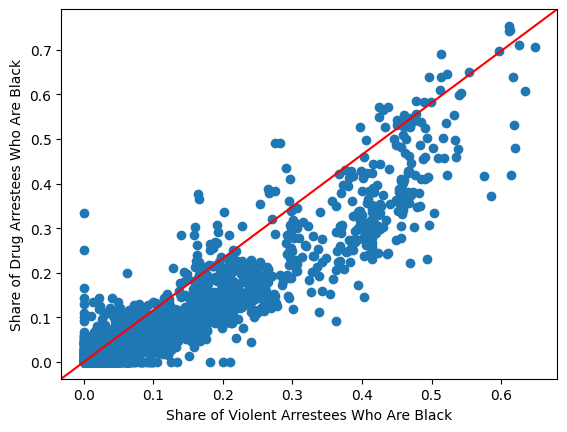

In [250]:
# Filter out FutureWarnings
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

# plot share of violent arrestees who are black vs share of drug arrestees who are black

import matplotlib.pyplot as plt

merged_arrest_black = merged_arrest[merged_arrest["RACE"] == "Black"]

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the data
ax.scatter(
    merged_arrest_black["share_violent_arrests"],
    merged_arrest_black["share_drug_arrests"],
)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, color="red")


# Set the labels for the x and y axes
ax.set_xlabel("Share of Violent Arrestees Who Are Black")
ax.set_ylabel("Share of Drug Arrestees Who Are Black")

# Display the plot
plt.show()

> From the scatter plot that shows a comparison between the share of drug arrestees who are Black and the share of violent arrestees who are Black, it shows that Black arrestees make up a greater share of violent arrestees. 
> Points below the red line indicate areas where the share of violent arrestees who are Black is higher than the share of drug arrestees who are Black. 

In [251]:
results["ex12_proportionate"] = "greater violent"

# results

In [252]:
assert set(results.keys()) == {
    "ex4_num_rows",
    "ex5_collapsed_vars",
    "ex7_alameda_1980_share_violent_arrestees_black",
    "ex11_white_drug_share",
    "ex11_black_drug_share",
    "ex12_proportionate",
}